In [1]:
%matplotlib inline
import numpy as np
import networkx as nx


In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocateor, FormatStrFormatter
%config InlineBackend.figure_format 'svg'

ImportError: cannot import name 'LinearLocateor' from 'matplotlib.ticker' (C:\Users\dipes\anaconda3\lib\site-packages\matplotlib\ticker.py)

In [4]:
from matplotlib.ticker import LinearLocateror

ImportError: cannot import name 'LinearLocateror' from 'matplotlib.ticker' (C:\Users\dipes\anaconda3\lib\site-packages\matplotlib\ticker.py)

In [20]:
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [7]:
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

In [13]:
n = 5
V = np.arange(0,n,1)
E = [(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)]
G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)



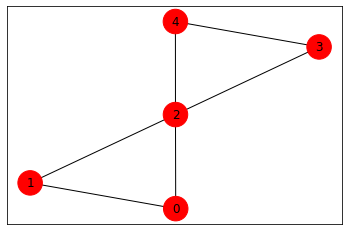

In [15]:
colors = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos =nx.spring_layout(G)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

In [16]:
step_size = 0.1;
a_gamma = np.arange(0, np.pi, step_size)
a_beta = np.arange(0,np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)
F1 = 3-(np.sin(2*a_beta)**2*np.sin(2*a_gamma)**2-0.5*np.sin(4*a_beta)*np.sin(4*a_gamma))*(1+np.cos(4*a_gamma)**2)
result = np.where(F1 == np.amax(F1))
a = list(zip(result[0],result[1]))[0]

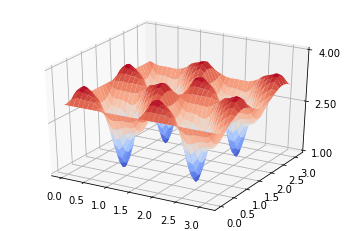


 --- OPTIMAL PARAMETERS --- 

The maximal expectation values is: M1 = 3.431
This is attained for gamma = 1.900 and beta = 0.200


In [21]:
gamma = a[0]*step_size;
beta = a[1]*step_size;
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax.set_zlim(1,4)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.show()
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation values is: M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %0.3f' %(gamma,beta))

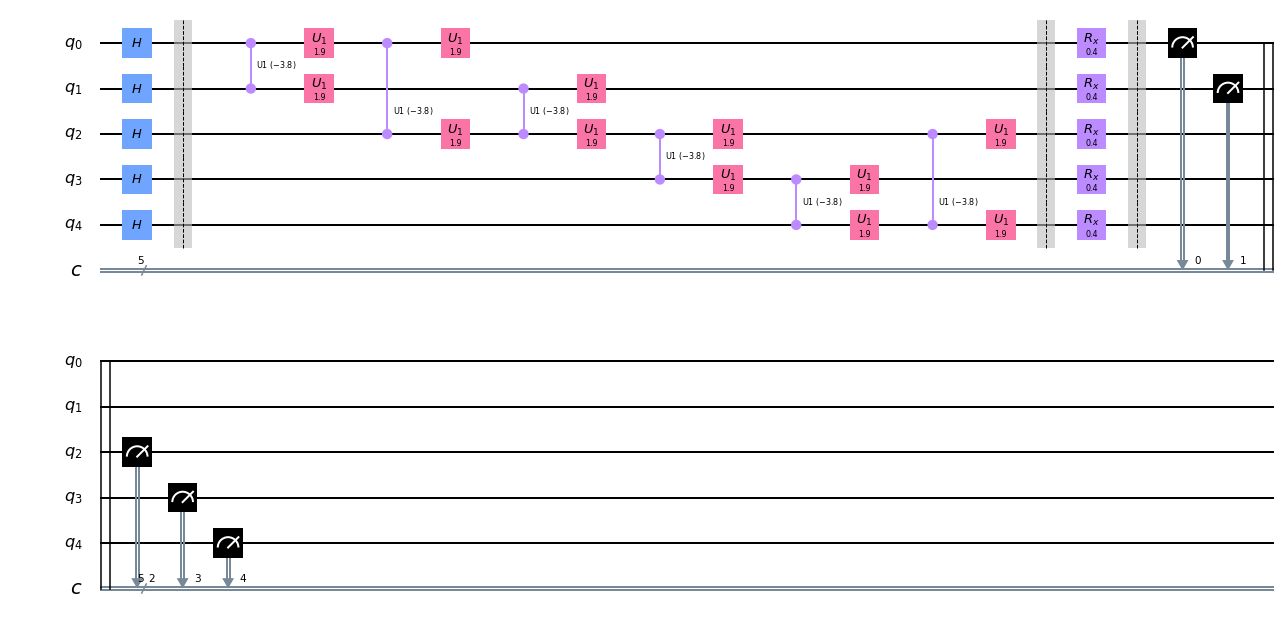

In [23]:
QAOA = QuantumCircuit(len(V), len(V))
QAOA.h(range(len(V)))
QAOA.barrier()
for edge in E:
    k = edge[0]
    l = edge[1]
    QAOA.cu1(-2*gamma, k, l)
    QAOA.u1(gamma, k)
    QAOA.u1(gamma, l)
QAOA.barrier()
QAOA.rx(2*beta, range(len(V)))
QAOA.barrier()
QAOA.measure(range(len(V)), range(len(V)))
QAOA.draw(output='mpl')

In [24]:
def cost_function_C(x,G):
    E = G.edges()
    if (len(x) !=len(G.nodes())):
        return np.nan
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        w = G[e1][e2]['weight']
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
    return C

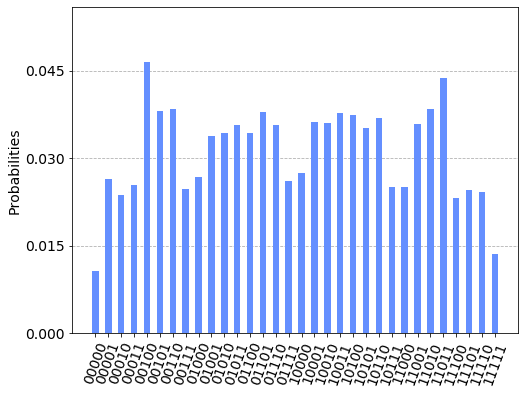

In [26]:
backend = Aer.get_backend("qasm_simulator")
shots = 10000
simulate = execute(QAOA, backend=backend, shots=shots)
QAOA_results = simulate.result()
plot_histogram(QAOA_results.get_counts(),figsize = (8,6), bar_labels = False)


 ---SIMULATION RESULTS---

The sampled mean value is M1_sampled = 3.30 while the true value is M1 = 3.43 

The approximate solution is x* = 10110 with C(x*) = 4 

The Cost function is distributed as: 



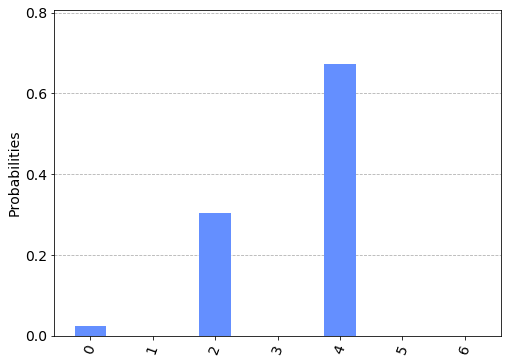

In [28]:
counts = QAOA_results.get_counts()
avr_C = 0
max_C = [0,0]
hist = {}
for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k), 0)
for sample in list(counts.keys()):
    x = [int(num) for num in list(sample)]
    tmp_eng = cost_function_C(x,G)
    avr_C = avr_C + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) +counts[sample]
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
M1_sampled = avr_C/shots
print('\n ---SIMULATION RESULTS---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The Cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

In [29]:
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_essex')
shots = 2048
job_exp = execute(QAOA, backend=backend, shots=shots)
job_monitor(job_exp)

Job Status: job has successfully run


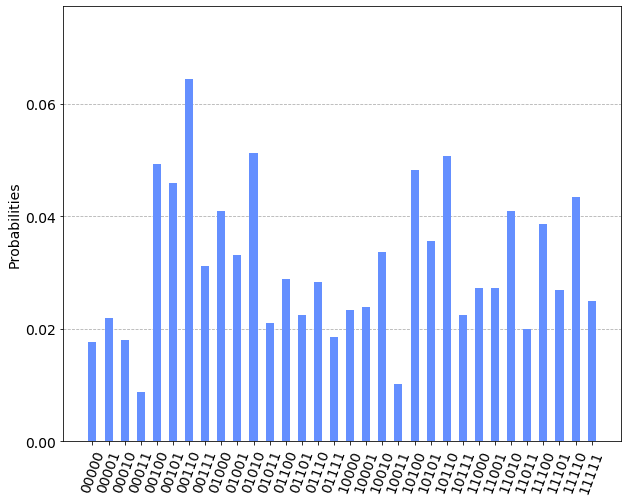

In [31]:
exp_results = job_exp.result()
plot_histogram(exp_results.get_counts(),figsize = (10,8), bar_labels = False)


 ---SIMULATION RESULTS---

The sampled mean value is M1_sampled = 3.19 while the true value is M1 = 3.43 

The approximate solution is x* = 10110 with C(x*) = 4 

The Cost function is distributed as: 



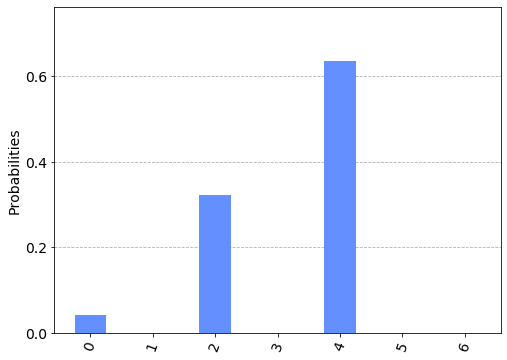

In [33]:
counts = exp_results.get_counts()
avr_C = 0
max_C = [0,0]
hist = {}
for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)
    
for sample in list(counts.keys()):
    x = [int(num) for num in list(sample)]
    tmp_eng = cost_function_C(x,G)
    avr_C = avr_C + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    if (max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
M1_sampled = avr_C/shots
print('\n ---SIMULATION RESULTS---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The Cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)